# 導入模組

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import numpy_financial as npf
import datetime
import tejapi
tejapi.ApiConfig.api_key = 'ahgk1NUSBtDTOb8ODUFzDz3rxyzIZ5'

# 資料庫

In [205]:
# 資料撈取
df = tejapi.get(
        'TRAIL/TAPRCD', 
        coid = '2330',
        opts={'columns': ['mdate', 'open_d', 'high_d', 'low_d', 'close_d', 'volume']}
#         paginate=True
        )

df['mdate'] = df.loc[:,'mdate'].astype('datetime64[ns]')

In [206]:
df

,mdate,open_d,high_d,low_d,close_d,volume
None,,,,,,
0,2020-01-02,332.5,339.0,332.5,339.0,33282.120
1,2020-01-03,344.0,345.0,335.5,339.5,42023.268
2,2020-01-06,333.0,334.5,332.0,332.0,45677.057
3,2020-01-07,332.5,333.0,326.5,329.5,51746.181
4,2020-01-08,325.0,333.0,325.0,329.5,37913.748
...,...,...,...,...,...,...
240,2020-12-25,514.0,515.0,510.0,511.0,12581.145
241,2020-12-28,512.0,515.0,509.0,515.0,19520.886
242,2020-12-29,515.0,517.0,513.0,515.0,20226.736


# 移動平均線

In [207]:
df['SMA'] = df['close_d'].rolling(15).mean()

In [208]:
df

,mdate,open_d,high_d,low_d,close_d,volume,SMA
None,,,,,,,
0,2020-01-02,332.5,339.0,332.5,339.0,33282.120,NaN
1,2020-01-03,344.0,345.0,335.5,339.5,42023.268,NaN
2,2020-01-06,333.0,334.5,332.0,332.0,45677.057,NaN
3,2020-01-07,332.5,333.0,326.5,329.5,51746.181,NaN
4,2020-01-08,325.0,333.0,325.0,329.5,37913.748,NaN
...,...,...,...,...,...,...,...
240,2020-12-25,514.0,515.0,510.0,511.0,12581.145,512.200000
241,2020-12-28,512.0,515.0,509.0,515.0,19520.886,512.266667
242,2020-12-29,515.0,517.0,513.0,515.0,20226.736,511.666667


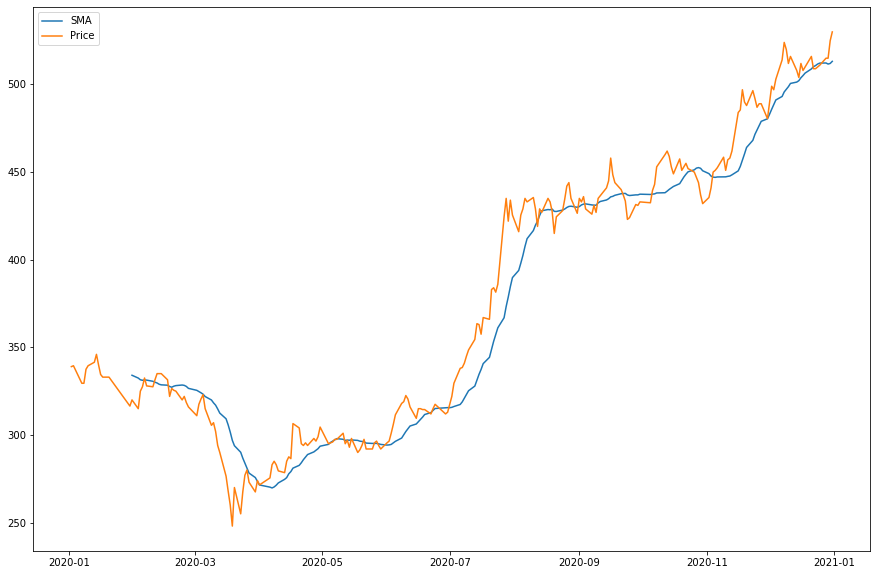

In [209]:
plt.figure(figsize=(15, 10))
plt.plot(df['mdate'], df['SMA'], label='SMA')
plt.plot(df['mdate'], df['close_d'], label='Price')
plt.legend()

# 計算移動平均與價格的差異

In [210]:
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [211]:
df['dif'] = df['close_d'] - df['SMA']
df

,None,mdate,open_d,high_d,low_d,close_d,volume,SMA,dif
0,14,2020-01-31,323.0,323.5,319.0,320.0,62912.055,334.066667,-14.066667
1,15,2020-02-03,315.0,316.5,312.0,315.0,59711.849,332.466667,-17.466667
2,16,2020-02-04,319.0,326.0,318.0,325.0,52208.496,331.500000,-6.500000
3,17,2020-02-05,329.0,329.5,324.5,327.5,36601.453,331.200000,-3.700000
4,18,2020-02-06,329.5,332.5,329.0,332.5,29659.094,331.400000,1.100000
...,...,...,...,...,...,...,...,...,...
226,240,2020-12-25,514.0,515.0,510.0,511.0,12581.145,512.200000,-1.200000
227,241,2020-12-28,512.0,515.0,509.0,515.0,19520.886,512.266667,2.733333
228,242,2020-12-29,515.0,517.0,513.0,515.0,20226.736,511.666667,3.333333
229,243,2020-12-30,516.0,525.0,514.0,525.0,46705.107,512.000000,13.000000


# 制定交易策略

- 當價格向上穿越移動平均：買入
- 當價格向下穿越移動平均：賣出
- 最後一天平倉

In [212]:
def print_info(last_buy, current_price, act, profit):
    print('Entering Price: ', last_buy)
    print('Exit Price: ', current_price)
    print('Position: ', str(act))
    print('Profit: ', profit)
    print()

In [220]:
buys = {}
sells = {}
position = None
profit_list = []
profit = 0
l = df['dif'].tolist()

for i in range(len(l)):
    current = l[i]
    past = l[i-1]
    
    current_price = df.iloc[i]['close_d']
    
    # 執行交易
    if current < 0 and past > 0:
        sells.update({i:current_price})
        position = 'Sell'
        
        # 確認是否第一筆交易
        if len(buys) > 0:
            # 計算距離上次的損益
            last_buy = buys[max(buys.keys())]
            profit += current_price - last_buy
            print_info(last_buy, current_price, 'Buy', profit)
            profit_list.append(profit)
        
    elif current > 0 and past < 0:
        buys.update({i:current_price})
        position = 'Buy'
        # 確認是否第一筆交易
        if len(sells) > 0:
            #計算距離上次的損益
            last_sell = sells[max(sells.keys())]
            profit += last_sell - current_price
            print_info(last_buy, current_price, 'Sell', profit)
            profit_list.append(profit)
        
    # 結算損益
    if i == len(l) -1:
        if position == 'Buy':
            sells.update({i:current_price})
            
            #計算距離上次的損益
            last_buy = buys[max(buys.keys())]
            profit += current_price - last_buy
            print_info(last_buy, current_price, 'Buy', profit)
            profit_list.append(profit)

        else:
            buys.update({i:current_price})
             
            #計算距離上次的損益
            last_sell = sells[max(sells.keys())]
            profit += last_sell - current_price
            print_info(last_buy, current_price, 'Sell', profit)
            profit_list.append(profit)
      

Entering Price:  515.0
Exit Price:  332.5
Position:  Sell
Profit:  -12.5

Entering Price:  332.5
Exit Price:  328.0
Position:  Buy
Profit:  -17.0

Entering Price:  332.5
Exit Price:  331.5
Position:  Sell
Profit:  -20.5

Entering Price:  331.5
Exit Price:  322.0
Position:  Buy
Profit:  -30.0

Entering Price:  331.5
Exit Price:  274.0
Position:  Sell
Profit:  18.0

Entering Price:  274.0
Exit Price:  295.5
Position:  Buy
Profit:  39.5

Entering Price:  274.0
Exit Price:  297.5
Position:  Sell
Profit:  37.5

Entering Price:  297.5
Exit Price:  297.5
Position:  Buy
Profit:  37.5

Entering Price:  297.5
Exit Price:  301.0
Position:  Sell
Profit:  34.0

Entering Price:  301.0
Exit Price:  295.0
Position:  Buy
Profit:  28.0

Entering Price:  301.0
Exit Price:  298.0
Position:  Sell
Profit:  25.0

Entering Price:  298.0
Exit Price:  290.0
Position:  Buy
Profit:  17.0

Entering Price:  298.0
Exit Price:  297.5
Position:  Sell
Profit:  9.5

Entering Price:  297.5
Exit Price:  292.0
Position:  B

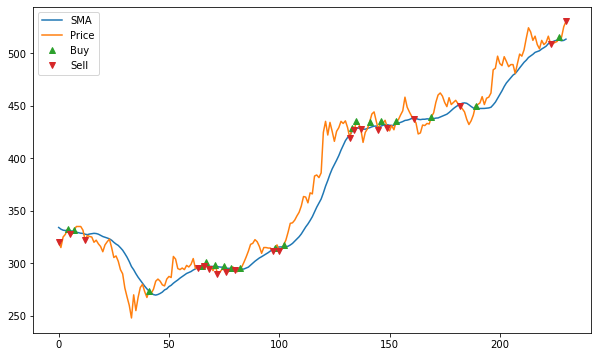

In [230]:
plt.figure(figsize=(10, 6))
plt.plot(df['SMA'], label='SMA')
plt.plot(df['close_d'], label='Price')
plt.plot(list(buys.keys()), list(buys.values()), '^', label='Buy')
plt.plot(list(sells.keys()), list(sells.values()), 'v', label='Sell')
plt.legend()

# 檢視此策略獲利

In [215]:
profit

119.0

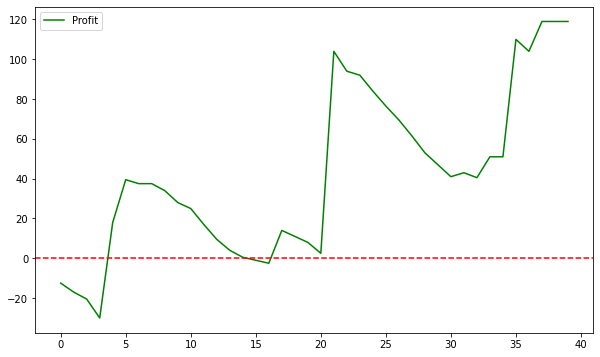

In [231]:
plt.figure(figsize=(10, 6))
plt.plot(profit_list, label='Profit', color='g')
profit_list.append(profit)
plt.legend()
plt.axhline(0, color= 'r', linestyle='--')

# 買入持有策略獲利

In [216]:
df.iloc[-1]['close_d'] - df.iloc[0]['close_d']

210.0